# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [20]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [21]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [22]:
import numpy as np

np.random.normal(10,2)

11.035564816790092

In [23]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = np.random.normal(7.5*60, 2.5*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=702.769906018762, mobile=True), User(purchased=True, time_on_site=347.59020059118643, mobile=False), User(purchased=True, time_on_site=550.3807810780138, mobile=False), User(purchased=True, time_on_site=574.3873656467194, mobile=True), User(purchased=True, time_on_site=694.8604401595921, mobile=True), User(purchased=True, time_on_site=340.22014224561946, mobile=True), User(purchased=False, time_on_site=620.9705570506504, mobile=True), User(purchased=False, time_on_site=489.6244145611221, mobile=True), User(purchased=False, time_on_site=419.6130144980601, mobile=True), User(purchased=True, time_on_site=728.9382696758877, mobile=True)]


In [24]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,702.769906,True
1,True,347.590201,False
2,True,550.380781,False
3,True,574.387366,True
4,True,694.860440,True


In [25]:
# Convert seconds to minutes (for comparison)
user_data['time_on_site_min'] = user_data['time_on_site'] / 60
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,True,702.769906,True,11.712832
1,True,347.590201,False,5.793170
2,True,550.380781,False,9.173013
3,True,574.387366,True,9.573123
4,True,694.860440,True,11.581007


In [26]:
# Find negative time data
user_data[user_data.time_on_site < 0.0]

,purchased,time_on_site,mobile,time_on_site_min
440,True,-71.862791,True,-1.197713


In [27]:
# Assign negative time_on_site values to 0.0
user_data.loc[user_data['time_on_site'] < 0.0, 'time_on_site'] = 0.0
user_data[user_data.time_on_site < 0.0] # confirm no zeros

,purchased,time_on_site,mobile,time_on_site_min


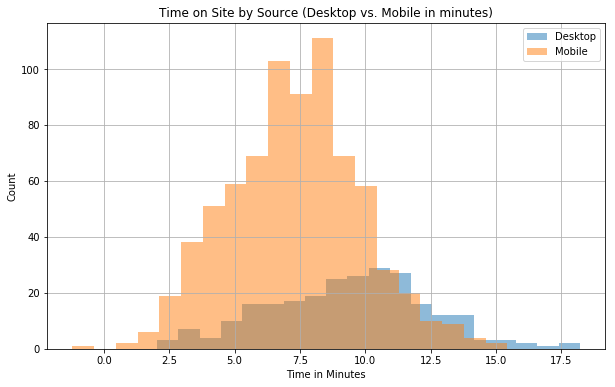

In [28]:
import matplotlib.pyplot as plt

user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5, figsize=(10,6));
plt.title('Time on Site by Source (Desktop vs. Mobile in minutes)');
plt.ylabel('Count')
plt.xlabel('Time in Minutes')
plt.legend(['Desktop','Mobile']);

In [29]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,0.0,28.368534275135232,76.335631155295,79.87292631253547,87.02792029357636,88.88850806336865,102.85597959525035,106.65398058375524,112.5481096627999,122.90156322454618,130.68179982625867,136.4517440383956,147.79996740099477,148.4935448265358,148.86595080721537,152.0001990463643,152.21825944369658,153.7585293675814,155.7936928408883,158.4972880062947,159.0290251126624,160.6031605798205,163.8893495620299,164.12847356189053,164.799704767499,166.00000228906254,168.98493271082202,172.9179625327239,173.42493515487797,173.9558784479653,174.86446200740193,175.28916216212787,177.43572210897622,177.97282021167268,178.35192615229022,179.33055972798968,185.7688028647073,188.69463855794226,189.2813403725305,190.1751956895822,...,784.4421837571349,785.1090245821748,792.794898849553,798.0601368029186,798.3239879551995,800.1569432933302,800.5254060123239,802.2593010934295,806.9079284926721,807.3138455110084,814.2098573558034,814.8722341001344,815.7933524089585,815.8126331040379,816.9672352784985,820.3077407223016,820.9752801769259,823.7031517769715,826.2842736305745,829.655892839681,831.305001364796,831.4772802711116,831.9865363075728,833.6484625772483,840.0849063931153,848.6615472384949,868.0655924308215,872.1797030742737,880.9536093125354,893.6562086375451,898.3852952496769,909.3905513821322,926.3997808769961,928.5449870965974,942.9041348949803,979.1079928699486,993.1560436832747,1024.5030104357743,1073.7766367014115,1092.1054243694098
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,1,0,0,0,1,1,0,1,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0
True,1,0,0,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1,1,1,0,1,1,0,1,1,0,1,0,0,1,0,...,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1,0,1,1,0,1,1,0,0,1,1,1,1


In [31]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-1.217, 2.682]",0.026726,0.018149
"(2.682, 6.562]",0.342984,0.283122
"(6.562, 10.442]",0.478842,0.513612
"(10.442, 14.322]",0.142539,0.166969
"(14.322, 18.202]",0.008909,0.018149


In [32]:
pd.crosstab(columns=user_data['purchased'], index=time_bins, normalize='index')

purchased,False,True
time_on_site_min,,
"(-1.217, 2.682]",0.545455,0.454545
"(2.682, 6.562]",0.496774,0.503226
"(6.562, 10.442]",0.431727,0.568273
"(10.442, 14.322]",0.410256,0.589744
"(14.322, 18.202]",0.285714,0.714286


In [34]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-1.217, 2.682]",0.026726,0.018149
"(2.682, 6.562]",0.342984,0.283122
"(6.562, 10.442]",0.478842,0.513612
"(10.442, 14.322]",0.142539,0.166969
"(14.322, 18.202]",0.008909,0.018149


In [35]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.556,0.413333
True,0.444,0.586667


In [36]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')

purchased            False               True           
mobile               False     True      False     True 
time_on_site_min                                        
(-1.217, 2.682]   0.014388  0.032258  0.000000  0.022727
(2.682, 6.562]    0.230216  0.393548  0.117117  0.325000
(6.562, 10.442]   0.431655  0.500000  0.423423  0.536364
(10.442, 14.322]  0.294964  0.074194  0.396396  0.109091
(14.322, 18.202]  0.028777  0.000000  0.063063  0.006818

In [37]:
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-1.217, 2.682]",0.026726,0.018149
"(2.682, 6.562]",0.342984,0.283122
"(6.562, 10.442]",0.478842,0.513612
"(10.442, 14.322]",0.142539,0.166969
"(14.322, 18.202]",0.008909,0.018149


##Stanford open policing project

In [38]:
!unzip jb084sr9005_nj_statewide_2019_02_25.csv.zip
!ls

Archive:  jb084sr9005_nj_statewide_2019_02_25.csv.zip
  inflating: share/data/opp-for-archive/nj_statewide_2019_02_25.csv  
jb084sr9005_nj_statewide_2019_02_25.csv.zip  sample_data  share


In [39]:
%%time
df = pd.read_csv('./share/data/opp-for-archive/nj_statewide_2019_02_25.csv')
print(df.shape)

(3845334, 20)
CPU times: user 19.9 s, sys: 1.3 s, total: 21.2 s
Wall time: 21.2 s


In [40]:
df.head()

,raw_row_number,date,time,location,subject_race,subject_sex,officer_id_hash,department_id,type,violation,arrest_made,citation_issued,warning_issued,outcome,frisk_performed,search_conducted,vehicle_color,vehicle_make,vehicle_model,vehicle_registration_state
0,24723,2009-01-10,15:38:41,"31ST / CARMEN, Camden City",black,male,347f40fd4d,A010,vehicular,NaN,True,NaN,NaN,arrest,True,True,SIL,Chrysler,Town & Country,NJ
1,88239,2009-02-06,11:34:36,"@division, Ewing Twp",black,female,e84e551aad,A010,vehicular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101999,2009-02-11,01:34:26,"34TH / WESTFIELD, Camden City",black,male,e008ccd5a2,A010,vehicular,NaN,True,NaN,NaN,arrest,False,True,GRY,Chevrolet,NaN,PA
3,151289,2009-03-03,20:29:16,"MACARTHUR / 12TH, Camden City",black,male,b84c0f827e,A010,vehicular,NaN,True,NaN,NaN,arrest,True,True,BLU,Chevrolet,Tahoe,NJ
4,153223,2009-03-05,22:25:26,"FEDERAL / 10TH, Camden City",black,male,56eb37f85f,A010,vehicular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BLK,Ford,Expedition,NJ


In [41]:
df.isna().sum()

raw_row_number                      0
date                                0
time                                0
location                            0
subject_race                   109431
subject_sex                     18787
officer_id_hash                     0
department_id                       0
type                                0
violation                      916990
arrest_made                   3719812
citation_issued                852818
warning_issued                 858842
outcome                        845936
frisk_performed               3707675
search_conducted              3703294
vehicle_color                  102890
vehicle_make                   143182
vehicle_model                 2887636
vehicle_registration_state      27617
dtype: int64

In [42]:
# What are the most common violations?
df.violation.value_counts().head(10)

39:4-97 CARELESS DRIVING                          726267
39:4-98 RATES OF SPEED                            301189
39:4-88B UNSAFE LANE CHANGE                       218747
39:3-76.2F REQ WEARING SEATBELTS                  189408
39:4-56 DELAYING TRAFFIC                          165038
39:3-66 MAINTENANCE ILLUM DEVICE                  139425
39:4-97.3 USE OF HANDS-FREE WIRELESS TELEPHONE    126905
39:4-99 EXCEED SPEED LIMITATIONS                   96289
39:3-75 SAFETY GLASS DEFINED                       82905
39:3-74 WINDSHIELD WIPERS                          73668
Name: violation, dtype: int64

In [16]:
df.vehicle_make.value_counts(normalize=True).head(10)

Honda         0.118632
Ford          0.106514
Toyota        0.099623
Chevrolet     0.084403
Nissan        0.081274
Dodge         0.047225
Hyundai       0.037378
Jeep          0.035211
BMW           0.034904
Volkswagen    0.028908
Name: vehicle_make, dtype: float64

In [17]:
df[df.violation == '39:4-98 RATES OF SPEED'].vehicle_make.value_counts(normalize=True).head(10)

Honda            0.125034
Toyota           0.107939
Ford             0.088320
Nissan           0.084921
Chevrolet        0.074299
BMW              0.043302
Dodge            0.041296
Hyundai          0.039327
Volkswagen       0.032925
Mercedes-Benz    0.031556
Name: vehicle_make, dtype: float64

In [18]:
df[df.violation == '39:4-98 RATES OF SPEED'].vehicle_color.value_counts(normalize=True).head(10)

BLK    0.238954
SIL    0.200708
WHI    0.157833
GRY    0.110433
BLU    0.096752
RED    0.077175
GRN    0.043044
TAN    0.020111
GLD    0.019722
BGE    0.009164
Name: vehicle_color, dtype: float64

##%TimeIt

In [43]:
df = pd.DataFrame({'a': np.arange(1e6),
                  'b': 2*np.arange(1e6)})
print(df.shape)
df.head()

(1000000, 2)


,a,b
0,0.0,0.0
1,1.0,2.0
2,2.0,4.0
3,3.0,6.0
4,4.0,8.0


In [44]:
%timeit df['c'] = df['a']**2

100 loops, best of 3: 14.6 ms per loop


In [0]:
from tqdm import tqdm
tqdm.pandas()

In [46]:
%timeit df['c2'] = df['a'].apply(lambda x: x**2)

1 loop, best of 3: 307 ms per loop


In [47]:
%timeit df['c3'] = df['a'].progress_apply(lambda x: x**2)

100%|██████████| 1000000/1000000 [00:01<00:00, 705959.06it/s]

1 loop, best of 3: 1.42 s per loop


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [24]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
!pip install pandas==0.23.4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/crsanderford/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')

In [25]:
print(df.shape)
df.head()

(1200, 4)


,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


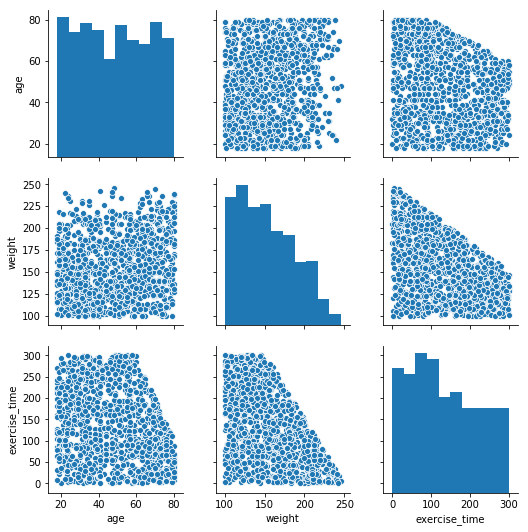

In [26]:
# Let's use a seaborn pairplot to see scatterplots of each feature versus the other. We'll omit the index.
import matplotlib.pyplot as plt
import seaborn as sns


sns.pairplot(df[['age','weight','exercise_time']])

In [27]:
# Age and weight look to have the weakest correlation. Weight and exercise time; and age and exercise time, have some pretty visible trends.
# We'll use some crosstabs to examine further - all our variables are continuous, so we'll look at mins and maxes to see where to break up the range.
print(df.age.min(),df.age.max())
print(df.weight.min(),df.weight.max())
print(df.exercise_time.min(),df.exercise_time.max())


18 80
100 246
0 300


In [0]:
# If we break each of these into 5 equal bins, we're getting brackets of about eight years of age, thirty pounds, and a minute of exercise time.
# That sounds pretty reasonable.

age_bins = pd.cut(df['age'], 5)
weight_bins = pd.cut(df['weight'], 5)
exercise_bins = pd.cut(df['exercise_time'], 5)

In [29]:
# Okay, crosstabs. First age and weight.
pd.crosstab(columns=age_bins, index=weight_bins, normalize='index')

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
weight,,,,,
"(99.854, 129.2]",0.213333,0.277333,0.208000,0.141333,0.160000
"(129.2, 158.4]",0.256716,0.185075,0.185075,0.211940,0.161194
"(158.4, 187.6]",0.189922,0.189922,0.189922,0.174419,0.255814
"(187.6, 216.8]",0.189944,0.173184,0.145251,0.245810,0.245810
"(216.8, 246.0]",0.132075,0.132075,0.150943,0.169811,0.415094


In [30]:
# That sort of makes sense. No intensely visible correlation, but for the lower weight brackets, percentages tend to go down as age increases.
# And for the higher weight brackets, percentages tend to increase as age increases. 

# Let's try age and exercise.
pd.crosstab(columns=age_bins, index=exercise_bins, normalize='index')

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
exercise_time,,,,,
"(-0.3, 60.0]",0.187050,0.187050,0.147482,0.165468,0.312950
"(60.0, 120.0]",0.145570,0.174051,0.132911,0.224684,0.322785
"(120.0, 180.0]",0.242152,0.188341,0.174888,0.179372,0.215247
"(180.0, 240.0]",0.317708,0.244792,0.177083,0.213542,0.046875
"(240.0, 300.0]",0.225131,0.298429,0.350785,0.125654,0.000000


In [31]:
# Here we get a much more obvious correlation. In the lower duration brackets, older individuals make up a greater share.
# And in the higher duration brackets, younger individuals make up a greater share.

# Now weight and exercise.
pd.crosstab(columns = weight_bins, index = exercise_bins, normalize='index')

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
exercise_time,,,,,
"(-0.3, 60.0]",0.190647,0.158273,0.219424,0.273381,0.158273
"(60.0, 120.0]",0.205696,0.240506,0.294304,0.231013,0.028481
"(120.0, 180.0]",0.318386,0.300448,0.251121,0.130045,0.000000
"(180.0, 240.0]",0.411458,0.385417,0.197917,0.005208,0.000000
"(240.0, 300.0]",0.560209,0.387435,0.052356,0.000000,0.000000


In [0]:
# This is also a pretty obvious correlation. Low duration brackets have some representation from the top two weight classes;
# but by the middle duration bracket, the highest weight bracket has dropped out completely, and the second highest barely there.

# Let's try holding a variable near-constant, and checking the correlation of the other two.

def age_filter(dataframe):
    return (dataframe['age'] > 42.8) & (dataframe['age'] <= 55.2)
  
def weight_filter(dataframe):
    return (dataframe['weight'] > 158.4) & (dataframe['weight'] <= 187.6)
  
def exercise_filter(dataframe):
    return (dataframe['exercise_time'] > 120.0) & (dataframe['exercise_time'] <= 180.0)

In [68]:
# We'll make three filtered dataframes.
# Age before beauty!

hold_age = df.copy()
hold_age = df[age_filter(df)]
hold_age.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
2,2,46,128,220
6,6,55,161,107
8,8,55,216,79
9,9,50,127,267


In [69]:
# Then weight.

hold_weight = df.copy()
hold_weight = df[weight_filter(df)]
hold_weight.head()

,Unnamed: 0,age,weight,exercise_time
1,1,41,161,35
6,6,55,161,107
10,10,21,160,228
13,13,27,165,48
14,14,21,169,171


In [70]:
# And exercise

hold_exercise = df.copy()
hold_exercise = df[exercise_filter(df)]
hold_exercise.head()

,Unnamed: 0,age,weight,exercise_time
5,5,58,103,165
14,14,21,169,171
17,17,69,172,147
33,33,70,169,172
34,34,32,163,175


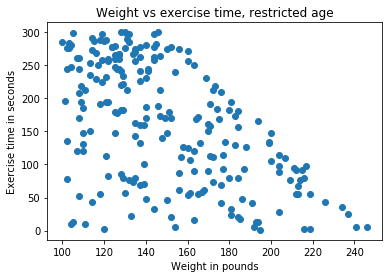

In [71]:
# Now for the scatterplots. Exercise and weight, age constant.

plt.scatter(hold_age['weight'], hold_age['exercise_time'])
plt.title('Weight vs exercise time, restricted age')
plt.xlabel('Weight in pounds')
plt.ylabel('Exercise time in seconds')
plt.show()

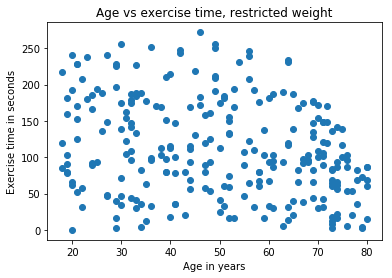

In [74]:
# Decent correlation there!

# Age and exercise, weight constant.

plt.scatter(hold_weight['age'], hold_weight['exercise_time'])
plt.title('Age vs exercise time, restricted weight')
plt.xlabel('Age in years')
plt.ylabel('Exercise time in seconds')
plt.show()

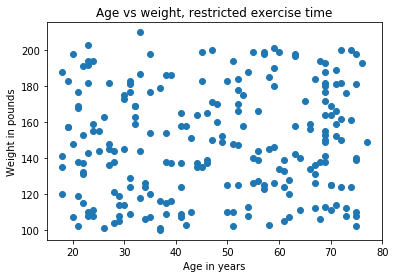

In [75]:
# A little weaker, but still something to be seen.

# Age and weight, exercise constant.

plt.scatter(hold_exercise['age'], hold_exercise['weight'])
plt.title('Age vs weight, restricted exercise time')
plt.xlabel('Age in years')
plt.ylabel('Weight in pounds')
plt.show()

In [0]:
# This one looks pretty lacking.

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

    All the variables are of type int, but can be thought of as being continuous.

2.  What are the relationships between the variables?

    Age vs weight is a weak positive correlation. Both age vs exercise time, and weight vs exercise time, have either a negative direct correlation, or an inverse correlation.

3.  Which relationships are "real", and which spurious?

  The relationship between age and weight is the one which appears to have the weakest correlation when the third variable (exercise time here) is held constant. The other two, weight vs exercise and age vs exercise, maintain a strong correlation even when they are restricted by narrowing the domain of the third variable.

### ECommerce Company responses

Approach problems:


*   By combining old legacy cookies with new legacy cookies, they allow for a confounder - business performance before and after the introduction of the new system. Business may simply have been better (or worse!) prior to their month of testing.
*   Old cookies are subject to *selection bias* - an old cookie is one that has survived for some time, whereas a new cookie very well may not. The most obvious reason why an old cookie would survive would be that old cookies represent *repeat customers*, who likely represent greater revenue.
*   Similarly, some customers may be the kind of people who delete cookies. Cookie-deleters may have some characteristics, like being unamenable to advertisements. Old cookies are largely free of this lower-revenue population.

Solutions:


*   Simply don't use old cookies along with new ones.
*   Use legacy cookies from before the test, but drop all cookies which have had a period of activity greater than a month.





## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

In [12]:
# Load in some data
bananas = pd.read_csv('PBANSOPUSDQ.csv')
print(bananas.shape)
bananas.head()

(53, 2)


,DATE,PBANSOPUSDQ
0,2006-01-01,792.302681
1,2006-04-01,776.619789
2,2006-07-01,558.715479
3,2006-10-01,603.763563
4,2007-01-01,648.554364


In [13]:
# Load in some more data
loans = pd.read_csv('SLOAS.csv')
print(loans.shape)
loans.head()

(53, 2)


,DATE,SLOAS
0,2006-01-01,480.96698
1,2006-04-01,487.12604
2,2006-07-01,510.54846
3,2006-10-01,521.38249
4,2007-01-01,544.98854


In [15]:
# Check for NaNs
bananas.isna().sum()

DATE           0
PBANSOPUSDQ    0
dtype: int64

In [16]:
bananas.isna().sum()

DATE           0
PBANSOPUSDQ    0
dtype: int64

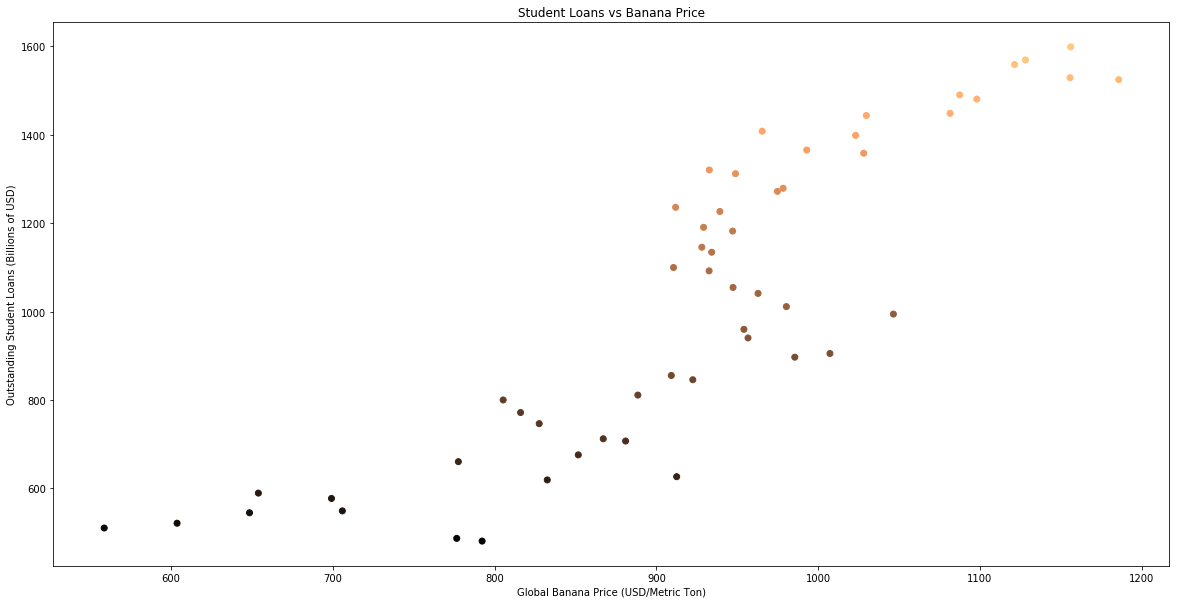

In [14]:
# No NaNs, scatterplot it.

fig = plt.figure(figsize = [20,10])

plt.scatter(bananas['PBANSOPUSDQ'], loans['SLOAS'], c=(loans.index), cmap='copper')
plt.title('Student Loans vs Banana Price')
plt.xlabel('Global Banana Price (USD/Metric Ton)')
plt.ylabel('Outstanding Student Loans (Billions of USD)')
plt.show()